# EDA of yelp review dataset

In [2]:
import polars as pl
import pandas as pd
import pyarrow
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from tqdm import tqdm
from itertools import chain
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from ollama import Client 

In [3]:
print(sys.executable)

c:\Users\moris\Desktop\large project\venv\Scripts\python.exe


### General informations

In [4]:
df = pl.read_ndjson('../data/original/yelp_dataset/yelp_academic_dataset_review.json')

print(df.head())

shape: (5, 9)
┌──────────────┬──────────────┬─────────────┬───────┬───┬───────┬──────┬─────────────┬─────────────┐
│ review_id    ┆ user_id      ┆ business_id ┆ stars ┆ … ┆ funny ┆ cool ┆ text        ┆ date        │
│ ---          ┆ ---          ┆ ---         ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---         ┆ ---         │
│ str          ┆ str          ┆ str         ┆ f64   ┆   ┆ i64   ┆ i64  ┆ str         ┆ str         │
╞══════════════╪══════════════╪═════════════╪═══════╪═══╪═══════╪══════╪═════════════╪═════════════╡
│ KU_O5udG6zpx ┆ mh_-eMZ6K5RL ┆ XQfwVwDr-v0 ┆ 3.0   ┆ … ┆ 0     ┆ 0    ┆ If you      ┆ 2018-07-07  │
│ Og-VcAEodg   ┆ WhZyISBhwA   ┆ ZS3_CbbE5Xw ┆       ┆   ┆       ┆      ┆ decide to   ┆ 22:09:11    │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ eat here,   ┆             │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ jus…        ┆             │
│ BiTunyQ73aT9 ┆ OyoGAe7OKpv6 ┆ 7ATYjTIgM3j ┆ 5.0   ┆ … ┆ 0     ┆ 1    ┆ I've

In [5]:
print("Dataset size :")
print(f"Number of rows : {df.height}")
print(f"Number of features/columns : {df.width}")

Dataset size :
Number of rows : 6990280
Number of features/columns : 9


In [6]:
print("Missing values by feature/column :")
missing_counts = df.null_count()
print(missing_counts)

Missing values by feature/column :
shape: (1, 9)
┌───────────┬─────────┬─────────────┬───────┬───┬───────┬──────┬──────┬──────┐
│ review_id ┆ user_id ┆ business_id ┆ stars ┆ … ┆ funny ┆ cool ┆ text ┆ date │
│ ---       ┆ ---     ┆ ---         ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32       ┆ u32     ┆ u32         ┆ u32   ┆   ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═══════════╪═════════╪═════════════╪═══════╪═══╪═══════╪══════╪══════╪══════╡
│ 0         ┆ 0       ┆ 0           ┆ 0     ┆ … ┆ 0     ┆ 0    ┆ 0    ┆ 0    │
└───────────┴─────────┴─────────────┴───────┴───┴───────┴──────┴──────┴──────┘


In [7]:
print("Features type :")
print(dict(zip(df.columns,df.dtypes)))

Features type :
{'review_id': String, 'user_id': String, 'business_id': String, 'stars': Float64, 'useful': Int64, 'funny': Int64, 'cool': Int64, 'text': String, 'date': String}


In [8]:
print("Different values:")
print(df.unique().count())

Different values:
shape: (1, 9)
┌───────────┬─────────┬─────────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ review_id ┆ user_id ┆ business_id ┆ stars   ┆ … ┆ funny   ┆ cool    ┆ text    ┆ date    │
│ ---       ┆ ---     ┆ ---         ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ u32       ┆ u32     ┆ u32         ┆ u32     ┆   ┆ u32     ┆ u32     ┆ u32     ┆ u32     │
╞═══════════╪═════════╪═════════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ 6990280   ┆ 6990280 ┆ 6990280     ┆ 6990280 ┆ … ┆ 6990280 ┆ 6990280 ┆ 6990280 ┆ 6990280 │
└───────────┴─────────┴─────────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘


### Distribution of stars per review

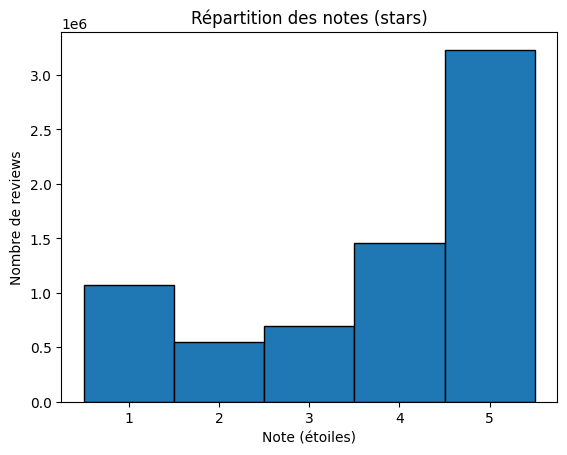

In [14]:
plt.hist(df["stars"], bins=range(1, 7), edgecolor="black", align="left")
plt.title("Répartition des notes (stars)")
plt.xlabel("Note (étoiles)")
plt.ylabel("Nombre de reviews")
plt.xticks(range(1, 6))
plt.show()

### Distribution of reviews date of publication

In [9]:
df = df.with_columns(
    pl.col("date")
    .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S")
    .alias("date_dt")
)

df = df.drop(["date"])

df = df.with_columns([
    pl.col("date_dt").dt.year().alias("year"),
    pl.col("date_dt").dt.month().alias("month"),
])

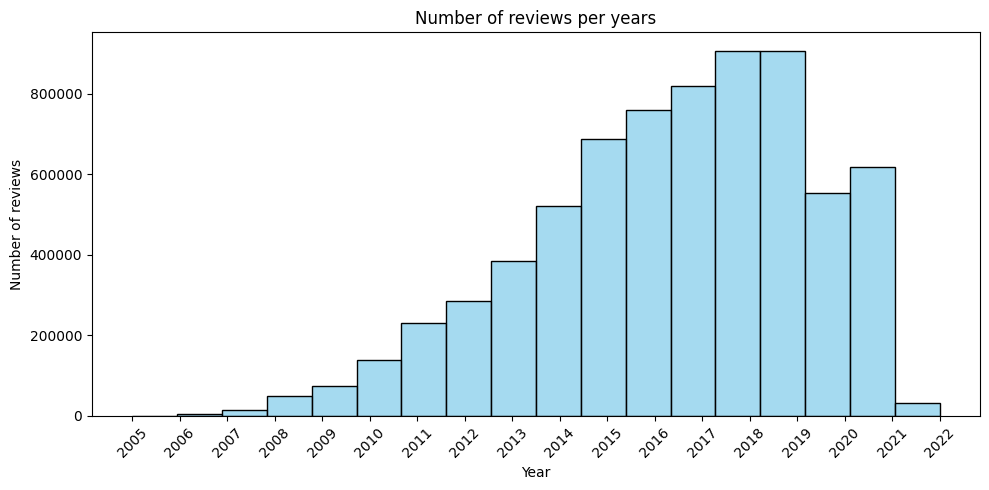

In [10]:
# conversion to pandas df to use matplotlib and seaborn
df_pd = df.select(["year", "month"]).to_pandas()

# util function to map month with season
def month_to_season(month: int) -> str:
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# conversion to pandas df to use matplotlib and seaborn
df_pd["season"] = df_pd["month"].apply(month_to_season)

# Histogramm about number of reviews per year
plt.figure(figsize=(10, 5))
sns.histplot(df_pd["year"], bins=df_pd["year"].nunique(), kde=False, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.title("Number of reviews per years")
plt.xticks(sorted(df_pd["year"].unique()), rotation=45)
plt.tight_layout()
plt.show()

We can see that the reviews of the dataset have mainly been pubished between 2014 and 2021 which means that some of them can be out dated. The freshness of the information is not ideal, and we must bear in mind that fresher information may be preferred when the POC goes into production.

C:\Users\moris\AppData\Local\Temp\ipykernel_24756\2965198275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


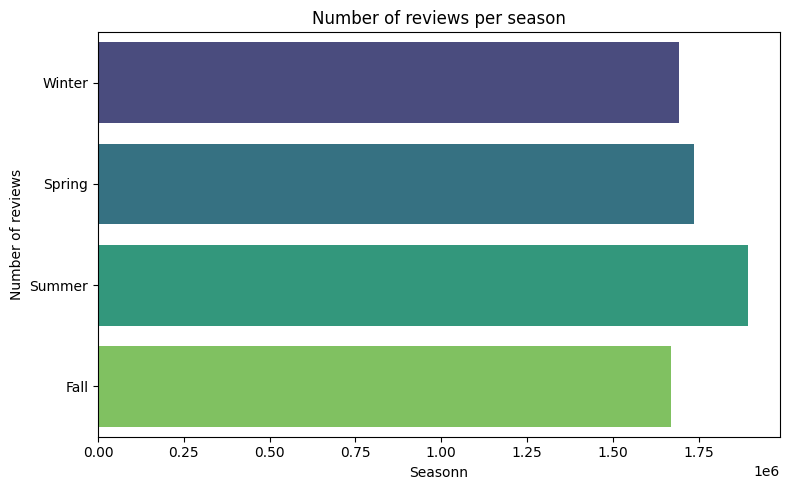

In [13]:
# Histogramm about number of reviews regarding the season
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_pd,
    y="season",
    order=["Winter", "Spring", "Summer", "Fall"],
    palette="viridis"
)
plt.xlabel("Seasonn")
plt.ylabel("Number of reviews")
plt.title("Number of reviews per season")
plt.tight_layout()
plt.show()

We can see that the distribution of reviews across the seasons is fairly balanced, with a slight increase in summer (the peak tourist season). This gives us a good understanding of travellers' preferences throughout the year.

### Word regex extraction

Our main goal here is to try to extarct the reviews related to special need travelers (people travelling with pets,people with disabilities, people with young children)

The keywords list is not exhaustive but we tend to extract the main part of the targeted reviews.

In [14]:
# key words
categories = {
    "handicap": [
        "handicap", "wheelchair", "accessible", "braille", "ramp", "lift", "elevator",
        "disabled", "barrier-free", "accessible toilet", "toilet accessible",
        "mobility aid", "adapted", "hearing aid", "visual impairment", "accessible entrance"
    ],
    "pets": [
        "dog", "cat", "pet", "animal", "rabbit", "hamster", "ferret", "pet-friendly",
        "animals allowed", "dog-friendly", "cat-friendly", "pet welcome"
    ],
    "children": [
        "child", "children", "baby", "kid", "stroller", "son", "daughter", "toddler",
        "infant", "playground", "high chair", "changing table", "family-friendly",
        "childcare", "kids menu", "baby seat"
    ]
}

# text normalisation
df_lower = df.select(pl.col("text").str.to_lowercase().alias("text"))

# count
keyword_summary = {}
category_summary = {}
for category, keywords in categories.items():
    cat_total = 0
    for kw in keywords:
        regex = r"\b" + re.escape(kw).replace("\\ ", "\\s+") + r"\b"
        count = (
            df_lower
            .select(pl.col("text").str.count_matches(regex).sum().alias("total"))
            .item()  # récupère la valeur scalaire
        )
        keyword_summary[kw] = int(count)
        cat_total += count
    category_summary[category] = int(cat_total)

# printing
print("\n=== Category count ===\n")
for cat, count in category_summary.items():
    print(f"{cat}: {count}")

print("\n=== Key words detail ===\n")
for kw, count in sorted(keyword_summary.items(), key=lambda x: (-x[1], x[0])):
    print(f"{kw}: {count}")



=== Category count ===

handicap: 54830
pets: 300134
children: 457931

=== Key words detail ===

dog: 186566
daughter: 112489
son: 100553
baby: 58097
kid: 58071
children: 57259
pet: 44292
child: 36910
cat: 35239
animal: 20981
elevator: 16699
accessible: 12456
rabbit: 10618
toddler: 10086
lift: 9309
playground: 7022
kids menu: 6141
wheelchair: 5279
disabled: 3817
stroller: 3284
ramp: 3193
handicap: 2931
infant: 2590
high chair: 2215
family-friendly: 1461
dog-friendly: 1395
changing table: 882
childcare: 818
adapted: 692
pet-friendly: 530
hamster: 345
braille: 192
hearing aid: 173
ferret: 143
accessible entrance: 66
baby seat: 53
visual impairment: 15
cat-friendly: 13
animals allowed: 10
barrier-free: 4
mobility aid: 3
pet welcome: 2
toilet accessible: 1
accessible toilet: 0


# Creation of a "clean" dataset

We will attemp to create a dataset of insightfull yelp reviews by processing the previous dataset.

We have seen that we can possibly find a considerable amount of data regarding each category : handicap,animals or children

However we need to focus on two things to have a more accurate dataset:

- **Context understanding**: some of our key words can be used in several contexts. For instance, the key word "rabbit" can reference the meat served in the restaurant but also the fact that the restaurant was allowing people to come with their rabbits. We have to extract the reviews that are usefull in a context of accessibility.
- **Sentiment analysis**: if we are considering about making recommandations we have to determine if the review was positive relatively to the key word sentence or negative.

By applying NLP processing to our data we will probably reduce the size of our dataset which will make it easier to identify outliers 


### Filtering reviews with key words in it

In [15]:
# key words list
all_keywords = [kw for kws in categories.values() for kw in kws]

# regex to detect one of the keyword
regex_keywords = r"\b(" + "|".join([re.escape(kw).replace("\\ ", "\\s+") for kw in all_keywords]) + r")\b"

# texte normalization
df_lower = df.select(pl.col("text").str.to_lowercase().alias("text"))

# mask of reviews containing at least one key word
mask = df_lower["text"].str.contains(regex_keywords)

# mini study dataset 
df_study = df_lower.filter(mask)

In [24]:
print(df_study.height)

499223


We've reduced the reviews number from almost 7 millions to around half a million

In [17]:
# Test GPU
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))


Torch version: 2.9.0+cu130
CUDA version: 13.0
Is CUDA available: True
Device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
BATCH_SIZE = 16

# Ollama client
client = Client() 

# utils functions
def filter_phrases_by_keywords(text, category_keywords):
    """Segmente le texte en phrases et garde celles contenant au moins un mot clé."""
    sentences = re.split(r'(?<=[.!?])\s+', text)
    filtered = []
    for sent in sentences:
        sent_lower = sent.lower()
        for kw in category_keywords:
            if kw.lower() in sent_lower:
                filtered.append(sent.strip())
                break
    return filtered

def classify_phrase_zero_shot(phrase, category, model_name="mistral"):

    prompt = f"""Phrase : "{phrase}"
                Question : Cette phrase indique-t-elle que le lieu est adapté à un voyageur avec des besoins spécifiques dans cette catégorie : {category} ? 
                Répondre strictement par "oui" ou "non" sans aucune justification. Ta réponse doit contenir un seul mot
                """
    response = client.generate(
        model=model_name,
        prompt=prompt, 
        options={'temperature': 0.0},
    )
    
    text = response['response'].lower()
    
    match = re.search(r"\b(oui|non)\b", text)
    return match.group(0) if match else "non"

def batch_classify_phrases(phrases, category):
    results = []
    for i in tqdm(range(0, len(phrases), BATCH_SIZE), desc=f"Classifying {category} phrases"):
        batch = phrases[i:i+BATCH_SIZE]
        batch_results = [classify_phrase_zero_shot(p, category) for p in batch]
        results.extend(batch_results)
    return results

# full pipeline
def process_reviews(df: pl.DataFrame, categories: dict) -> pd.DataFrame:
    relevant_reviews = []
    df_list_of_dicts = df.to_dicts() 

    for row_dict in tqdm(df_list_of_dicts, total=len(df_list_of_dicts), desc="Processing Reviews"):
        
        # Access column data using dictionary key
        text = row_dict.get('text')
        
        if not text:
            # Skip if the review text is missing
            continue

        review_result = {}

        for cat, keywords in categories.items():
            phrases = filter_phrases_by_keywords(text, keywords)
            if not phrases:
                review_result[cat] = "non"
                continue

            predictions = batch_classify_phrases(phrases, cat)
            review_result[cat] = "oui" if "oui" in predictions else "non"

        if any(v == "oui" for v in review_result.values()):
            # Create the final entry by merging original data and results
            relevant_reviews.append({**row_dict, **review_result})

    return pd.DataFrame(relevant_reviews)

In [ ]:
# pipeline execution
df_relevant = process_reviews(df_study, categories)
df_relevant.to_csv("reviews_pertinentes.csv", index=False)
print("Pipeline terminée. Nombre de reviews pertinentes :", len(df_relevant))

Processing Reviews:   0%|          | 376/499223 [03:17<69:52:07,  1.98it/s]